In [1]:
import requests 
from dotenv import load_dotenv
load_dotenv()
import sys, os
sys.path.append(os.path.join(os.path.dirname(''), '..'))
import pandas as pd
import json
import datetime
import numpy as np

#### <p style="font-family:verdana"> <span style='color: #138d75' > 1. Load the sales order want to make report for our stake holders.</span></p><p style="font-family:'Courier New'"><span style='color: #138d75' >TThis sales record was generated in the UK. We are based in Germany, so we need to convert from pounds to euros so that we can give our shareholders a direct and immediately comparable figure. It helps them to make decisions. </span></p>

In [2]:
df= pd.read_csv('orders.csv')
df_GBP=pd.read_csv('EURO2GBP_ex_changerate.csv')

#### <p style="font-family:verdana"> <span style='color: #138d75' > 2. Chunck only the completed order records for our report at this stage.</span></p><p style="font-family:'Courier New'"><span style='color: #138d75' >Let's select only the orders that were completed and already paid for. And have a overall check the data types and see what for a dataset we got.</span></p>

In [3]:
df = df[df['state']=='Completed']
df.sort_values(by=['created_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46605 entries, 1 to 226619
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      46605 non-null  int64  
 1   created_date  46605 non-null  object 
 2   total_paid    46605 non-null  float64
 3   state         46605 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.8+ MB


#### <p style="font-family:verdana"> <span style='color: #138d75' >3. Formate the column ['created_date'] Object into Dtype.</span></p><p style="font-family:'Courier New'"><span style='color: #138d75' >As we only want to go through a whole procedure. How do we get the foreign exchange(FX) conversion rate for that date through the API based on the guest's payment date. Let's just choose a random month of sales data here. Lest the data is too big and burns the CPU of the computer.</span></p>

In [4]:
df['created_date']= pd.to_datetime(df['created_date'], utc=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46605 entries, 1 to 226619
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      46605 non-null  int64         
 1   created_date  46605 non-null  datetime64[ns]
 2   total_paid    46605 non-null  float64       
 3   state         46605 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [5]:
df[(df['created_date'] < '2017-2-1 00:00:01') & (df['created_date'] >= '2016-12-31 23:59:00')]

,order_id,created_date,total_paid,state
6,245595,2017-01-21 12:52:47,112.97,Completed
8,245941,2017-01-01 10:32:23,183.52,Completed
21,254301,2017-01-08 13:10:53,35.91,Completed
25,254816,2017-01-12 15:57:20,283.83,Completed
42,260615,2017-01-10 18:59:49,225.16,Completed
...,...,...,...,...
19051,318531,2017-01-31 23:14:47,63.98,Completed
19052,318532,2017-01-31 23:18:50,276.78,Completed
19059,318539,2017-01-31 23:41:41,98.69,Completed
19062,318542,2017-01-31 23:35:14,90.24,Completed


In [6]:
df_GBP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   exchange_rate_date  35 non-null     object 
 1   GBP                 35 non-null     float64
dtypes: float64(1), object(1)
memory usage: 688.0+ bytes


<AxesSubplot:>

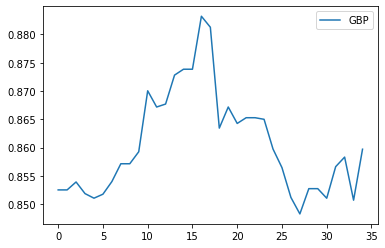

In [7]:
df_GBP.plot()